In [1]:
import numpy as np
import matplotlib.pyplot as plt
import decimal
from decimal import Decimal

# Gradient and hessian approximation

In [2]:
def grad_estimate_np(f, x: np.array, eps: decimal.Decimal):
    grad=np.full(len(x), Decimal(0))
    for i in range(len(x)):
        unit_vector = np.full(len(x), Decimal(0))
        unit_vector[i] = Decimal(1)
        grad[i] = round(float((f(x + (eps * unit_vector)) - f(x)) / eps), 15)
    return np.array(grad, dtype=float)

# use for further calculation of hessian estimate
def grad_estimate(f, x: np.array, eps: decimal.Decimal):
    grad=np.full(len(x), Decimal(0))
    for i in range(len(x)):
        unit_vector = np.full(len(x), Decimal(0))
        unit_vector[i] = Decimal(1)
        grad[i] = (f(x + (eps * unit_vector)) - f(x)) / eps
    return np.array(grad)


# Implementation of Flecher-Reeves and Polak-Ribiere

In [3]:
from scipy import optimize
x_star_1 = np.array([1,1])
e_g = Decimal(0.0000000000001)
max_iter = 10000

def Flechter_reeves(f, grad, x0, tol, c1, alpha_zero):
    x=x0
    gradient = grad(x)
    pk = -gradient
    gradient_norm = np.linalg.norm(gradient)
    run=0
    x_list = []
    while (gradient_norm > tol) and (run < max_iter):
        x_list.append(x)
        alpha = wolf_line_search(f, grad, x, pk,c1=c1)
        x_next=x+alpha*pk
        gradient = grad(x)
        gradient_norm = np.linalg.norm(gradient)
        gradient_next = grad(x_next)
        beta_FR = (np.dot(gradient_next.T,gradient_next))/(np.dot(gradient.T,gradient))
        pk = -gradient_next + beta_FR*pk
        #print(f"at x: {x_next} , pk: {pk}, grad: {gradient_next}")
        x=x_next
        run += 1
    dist = np.linalg.norm(x-x_star_1)
    return run, x, gradient_norm,dist,x_list

def Polak_ribiere(f, grad, x0, tol, c1, alpha_zero):
    x=x0
    gradient = grad(x)
    pk = -gradient

    gradient_norm = np.linalg.norm(gradient)
    run=0
    x_list = []
    while (gradient_norm > tol) and (run < max_iter):
        x_list.append(x)
        alpha = wolf_line_search(f, grad, x, pk,alpha_zero, c1=c1)
        if alpha == False:
            return False
        x_next=x+alpha*pk
        gradient = grad(x)
        gradient_norm = np.linalg.norm(gradient)
        gradient_next = grad(x_next)
        beta_PR = (np.dot(gradient_next.T,(gradient_next-gradient)))/(np.dot(gradient.T,gradient))
        pk = -gradient_next + beta_PR*pk
        #print(f"at x: {x_next} , pk: {pk}, grad: {gradient_next}")
        x=x_next
        run += 1
        dist = np.linalg.norm(x-x_star_1)
    return run, x, gradient_norm,dist,x_list

    
def Flechter_reeves_est(f, grad, x0, tol, c1, alpha_zero):
    e_g = Decimal(0.0000000000001)
    x=x0
    x_dec = np.array([Decimal(val) for val in x])
    gradient = grad(f,x_dec,e_g)
    pk = -gradient
    gradient_norm = np.linalg.norm(gradient)
    run=0
    x_list = []
    while (gradient_norm > tol) and (run < max_iter):
        x_dec = np.array([Decimal(val) for val in x])
        x_list.append(x)
        alpha = wolf_line_search_est(f, grad, x, pk,c1=c1)
        if alpha == False:
            return False
        x_next=x+alpha*pk
        x_next_dec = np.array([Decimal(val) for val in x_next])
        gradient = grad(f,x_dec,e_g)
        gradient_norm = np.linalg.norm(gradient)
        gradient_next = grad(f,x_next_dec,e_g)
        beta_FR = (np.dot(gradient_next.T,gradient_next))/(np.dot(gradient.T,gradient))
        pk = -gradient_next + beta_FR*pk
        
        x=x_next
        run += 1
    dist = np.linalg.norm(x-x_star_1)
    return run, x, gradient_norm,dist,x_list

def Polak_ribiere_est(f, grad, x0, tol, c1, alpha_zero):
    e_g = Decimal(0.0000000000001)
    x=x0
    x_dec = np.array([Decimal(val) for val in x])
    gradient = grad(f,x_dec,e_g)
    pk = -gradient

    gradient_norm = np.linalg.norm(gradient)
    run=0
    x_list = []
    while (gradient_norm > tol) and (run < max_iter):
        x_dec = np.array([Decimal(val) for val in x])
        x_list.append(x)
        alpha = wolf_line_search_est(f, grad, x, pk,alpha_zero, c1=c1)
        if alpha == False:
            return False
        x_next=x+alpha*pk
        x_next_dec = np.array([Decimal(val) for val in x_next])
        gradient = grad(f,x_dec,e_g)
        gradient_norm = np.linalg.norm(gradient)
        gradient_next = grad(f,x_next_dec,e_g)
        beta_PR = (np.dot(gradient_next.T,(gradient_next-gradient)))/(np.dot(gradient.T,gradient))
        pk = -gradient_next + beta_PR*pk
        #print(f"at x: {x_next} , pk: {pk}, grad: {gradient_next}")

        x=x_next
        run += 1
    dist = np.linalg.norm(x-x_star_1)
    return run, x, gradient_norm,dist,x_list


def wolf_line_search(f, grad,x, pk, alpha_zero=1, rho=0.95, c1=0.5):
    alpha = alpha_zero
    while (not f(x + alpha * pk) <= float(f(x)) + c1 * alpha * np.dot(grad(x).T, pk)):
        alpha *= rho
    return alpha

def wolf_line_search_est(f, grad,x, pk, alpha_zero=1, rho=0.95, c1=0.5):
    alpha = alpha_zero
    e_g = Decimal(0.0000000000001)
    x_dec = np.array([Decimal(val) for val in x])
    
    while (not f(x + alpha * pk) <= float(f(x)) + c1 * alpha * np.dot(grad(f,x_dec,e_g).T, pk)):
        alpha *= rho
    return alpha

def _plot_contour_map(f, x_min: float, x_max: float, y_min: float, y_max: float, fct_name: str, x_iter_cg: np.array, x_star: np.array, 
                      x_saddle_point:np.array = []):
    fig, ax = plt.subplots(figsize=(15, 15))

    X1, X2 = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
    Z = f([X1, X2])
    
    CS = ax.contourf(X1, X2, Z, 75)
    fig.colorbar(CS)
    #ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title(f'Contour Lines of f(x1,x2)={fct_name}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
    # annotate first and last x_k for cg
    ax.annotate('x0', (x_iter_cg[0, 0], x_iter_cg[0, 1]), size=16)
    ax.annotate(f'x{len(x_iter_cg)-1}', (x_iter_cg[-1, 0], x_iter_cg[-1, 1]), size=16)
    
    # annotate first and last x_k for nm
    #ax.annotate('x0', (x_iter_nm[0, 0], x_iter_nm[0, 1]), size=16)
    #ax.annotate('x1', (x_iter_nm[1, 0], x_iter_nm[1, 1]), size=16)
    #ax.annotate(f'x{len(x_iter_nm)}', (x_iter_nm[-1, 0], x_iter_nm[-1, 1]), size=16)
    
    ax.annotate('x*', x_star, size=16)
    
    # plot gradient lines for cg
    ax.plot(x_iter_cg[:, 0], x_iter_cg[:, 1], marker='o', color='red', linestyle='solid', label='CG')
    #ax.plot(x_iter_nm[:, 0], x_iter_nm[:, 1], marker='o', color='yellow', linestyle='solid', label='NM')
    
    # polt saddle_point
    if x_saddle_point != []:
        ax.plot(x_saddle_point[0], x_saddle_point[1], marker='o', color='green')
        ax.annotate('x_s', x_saddle_point, size=16)
    
    plt.legend()
    plt.show()

# Testing on given Problems

# Problem 1 (1.2, 1.2)

In [4]:
def fct_1(x: np.array) -> int:
    return 100*(x[1]-x[0]**2)**2 + (1-x[0])**2

def grad_fct_1(x: np.array) -> np.array:
    return np.array([-400*x[0]*(x[1]-x[0]**2)-2*(1-x[0]),
                    200*(x[1]-x[0]**2)], dtype=np.float64)
x_star_1 = np.array([1,1])

In [5]:
results=Flechter_reeves(fct_1, grad_fct_1, np.array([1.2, 1.2]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")
#print(results)

Number of iterates: 41 
final x: [1.00000028 1.00000057] 
gradient: 3.6224650726754323e-07 
distance: 6.324343065753569e-07


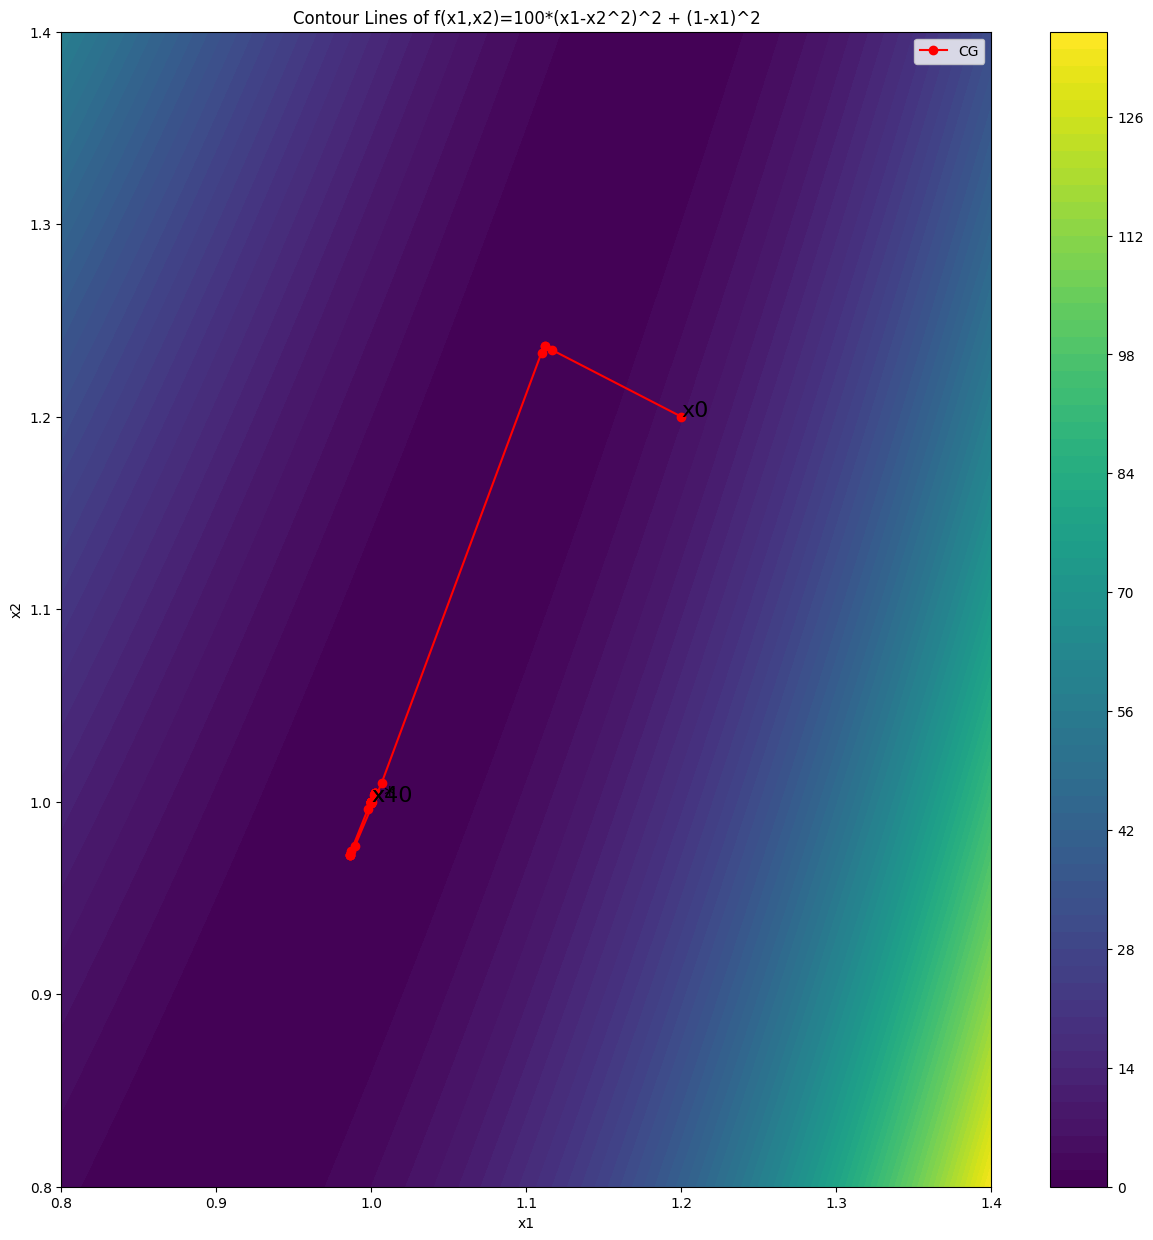

In [6]:
x_star = np.array([1,1])
_plot_contour_map(f=fct_1, x_min=0.8, x_max=1.4, y_min=0.8, y_max=1.4, fct_name='100*(x1-x2^2)^2 + (1-x1)^2', x_iter_cg=np.array(results[4]),  x_star=x_star)

In [7]:
results=Flechter_reeves_est(fct_1, grad_estimate_np, np.array([1.2, 1.2]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 41 
final x: [1.00000033 1.00000067] 
gradient: 5.807190095105914e-07 
distance: 7.472183496199614e-07


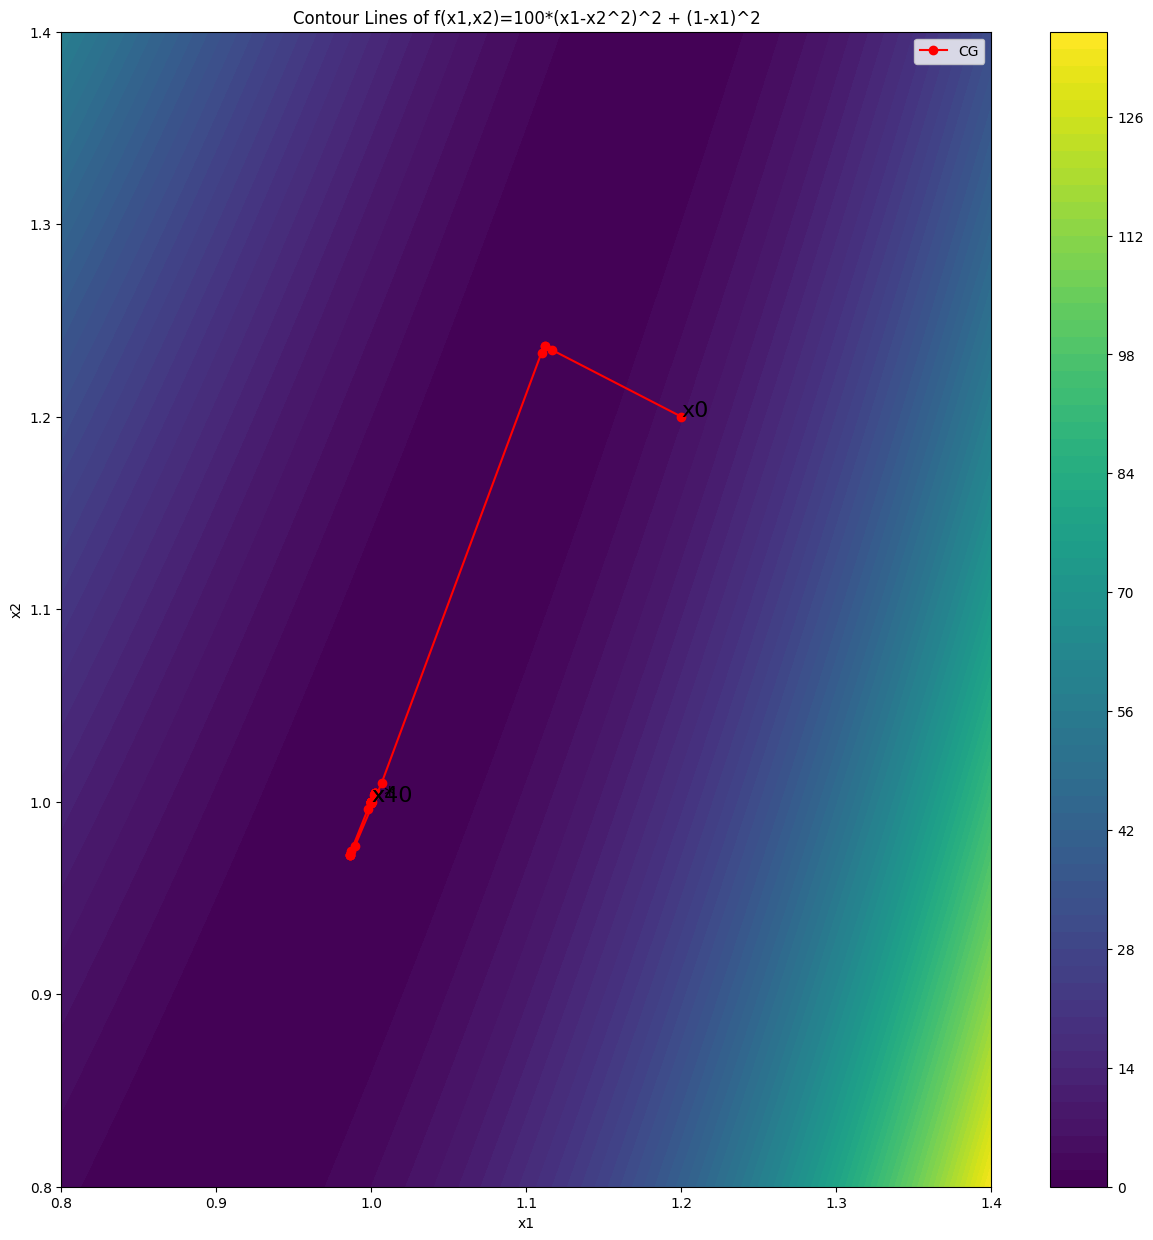

In [8]:
x_star = np.array([1,1])
_plot_contour_map(f=fct_1, x_min=0.8, x_max=1.4, y_min=0.8, y_max=1.4, fct_name='100*(x1-x2^2)^2 + (1-x1)^2', x_iter_cg=np.array(results[4]),  x_star=x_star)

In [9]:
b=Polak_ribiere(fct_1, grad_fct_1, np.array([1.2, 1.2]),10**-6, 0.5,1)
print(f"Number of iterates: {b[0]} \nfinal x: {b[1]} \ngradient: {b[2]} \ndistance: {b[3]}")

Number of iterates: 20 
final x: [1. 1.] 
gradient: 1.1956084547024401e-07 
distance: 2.6480233599516527e-09


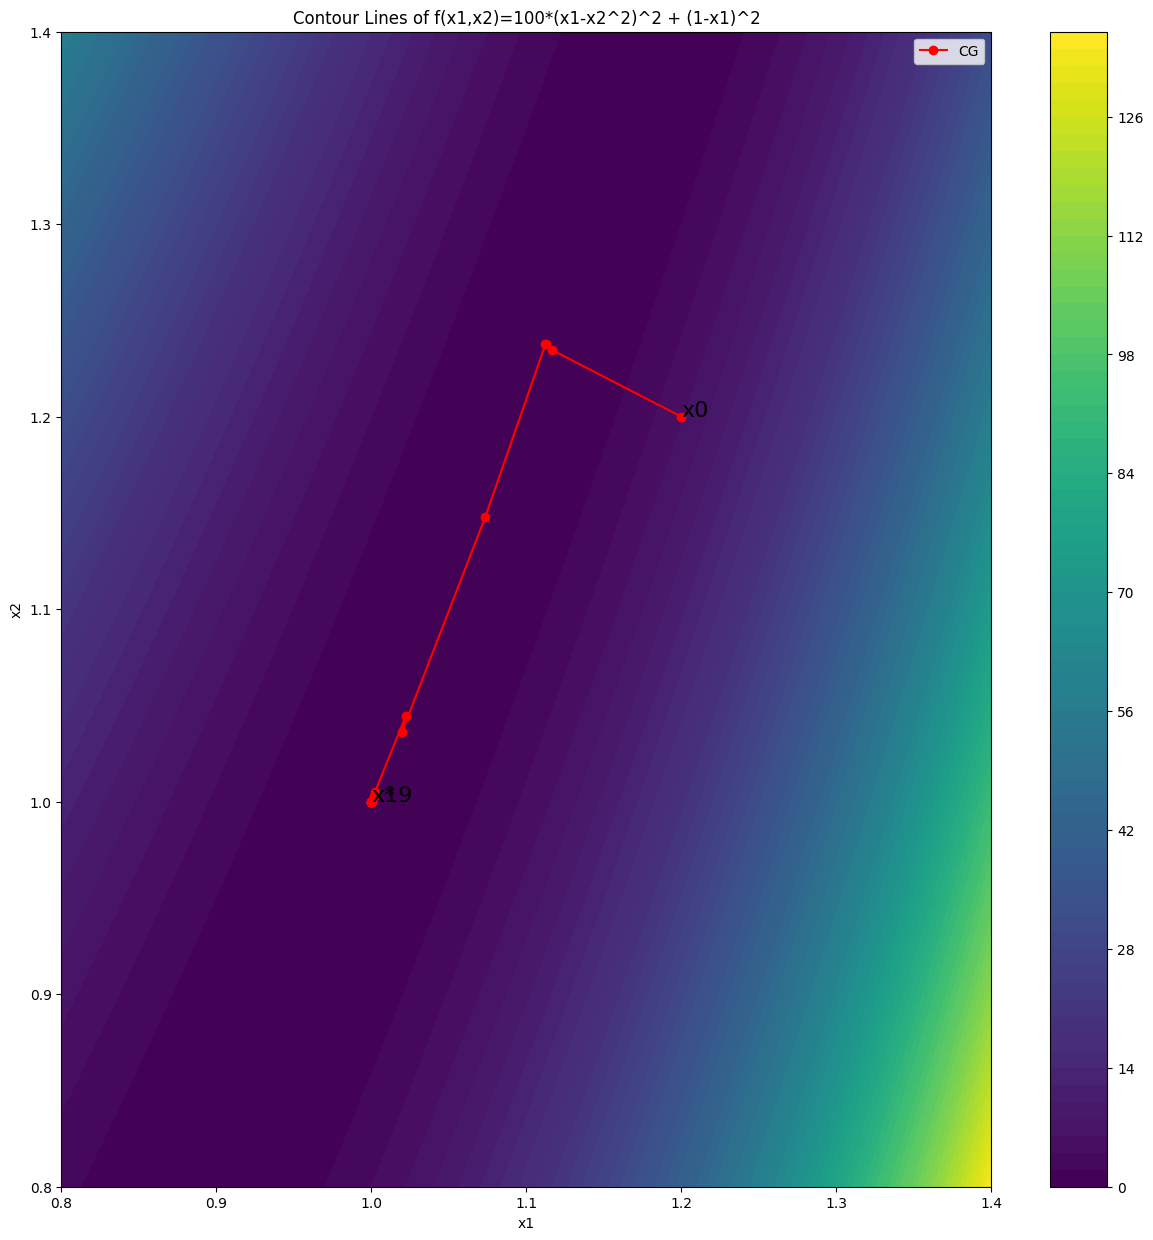

In [10]:
x_star = np.array([1,1])
_plot_contour_map(f=fct_1, x_min=0.8, x_max=1.4, y_min=0.8, y_max=1.4, fct_name='100*(x1-x2^2)^2 + (1-x1)^2', x_iter_cg=np.array(b[4]),  x_star=x_star)

In [11]:
b=Polak_ribiere_est(fct_1, grad_estimate_np, np.array([1.2, 1.2]),10**-6, 0.5,1)
print(f"Number of iterates: {b[0]} \nfinal x: {b[1]} \ngradient: {b[2]} \ndistance: {b[3]}")

Number of iterates: 20 
final x: [1. 1.] 
gradient: 1.2580875078193474e-07 
distance: 3.638098491553031e-09


# Problem 1 (-1.2, 1)

In [12]:
results=Flechter_reeves(fct_1, grad_fct_1, np.array([-1.2, 1]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 62 
final x: [0.9999998  0.99999959] 
gradient: 9.322613911533588e-07 
distance: 4.5815255463471446e-07


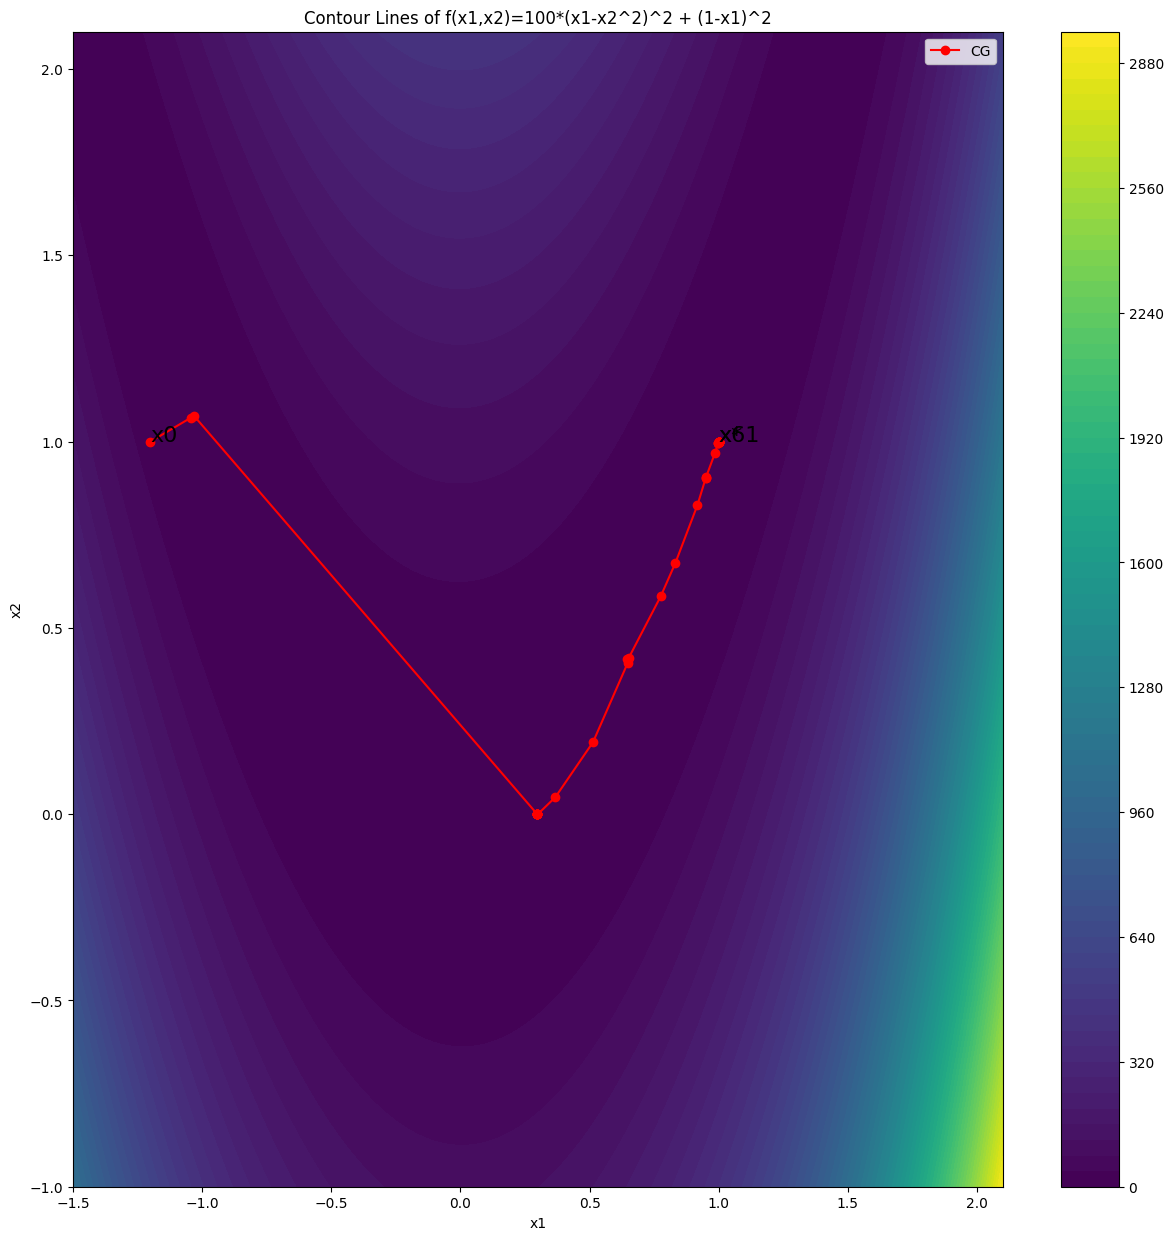

In [13]:
x_star = np.array([1,1])
_plot_contour_map(f=fct_1, x_min=-1.5, x_max=2.1, y_min=-1, y_max=2.1, fct_name='100*(x1-x2^2)^2 + (1-x1)^2', x_iter_cg=np.array(results[4]),  x_star=x_star)

In [14]:
results=Flechter_reeves_est(fct_1, grad_estimate_np, np.array([-1.2, 1]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 40 
final x: [1.00000004 1.00000008] 
gradient: 4.420453736206737e-07 
distance: 9.084788421803925e-08


In [15]:
b=Polak_ribiere(fct_1, grad_fct_1, np.array([-1.2, 1]),10**-6, 0.5,1)
print(f"Number of iterates: {b[0]} \nfinal x: {b[1]} \ngradient: {b[2]} \ndistance: {b[3]}")

Number of iterates: 42 
final x: [0.99999999 0.99999999] 
gradient: 1.3602819912005817e-07 
distance: 1.3795397251231246e-08


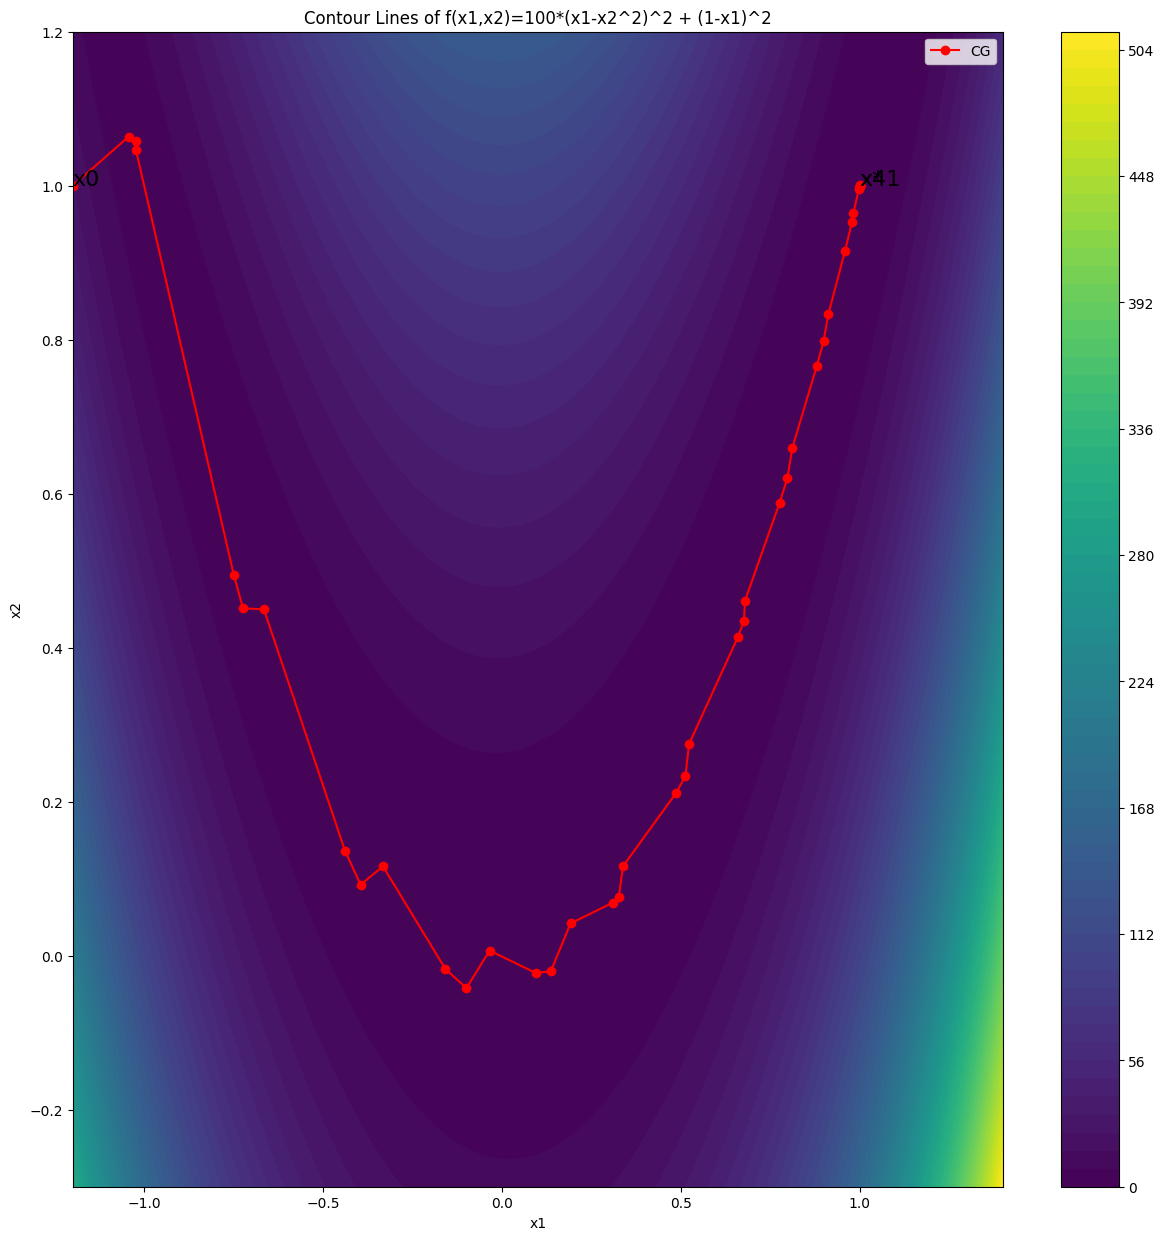

In [16]:
x_star = np.array([1,1])
_plot_contour_map(f=fct_1, x_min=-1.2, x_max=1.4, y_min=-0.3, y_max=1.2, fct_name='100*(x1-x2^2)^2 + (1-x1)^2', x_iter_cg=np.array(b[4]),  x_star=x_star)

In [17]:
b=Polak_ribiere_est(fct_1, grad_estimate_np, np.array([-1.2, 1]),10**-6, 0.5,1)
print(f"Number of iterates: {b[0]} \nfinal x: {b[1]} \ngradient: {b[2]} \ndistance: {b[3]}")

Number of iterates: 43 
final x: [1.00000021 1.00000042] 
gradient: 6.528460581995803e-07 
distance: 4.720985345328263e-07


# Problem 1 (0.2, 0.8)

In [18]:
results=Flechter_reeves(fct_1, grad_fct_1, np.array([0.2, 0.8]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 31 
final x: [1.00000001 1.00000003] 
gradient: 5.189221323772752e-07 
distance: 2.9181828230380727e-08


In [19]:
results=Flechter_reeves_est(fct_1, grad_estimate_np, np.array([0.2, 0.8]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 36 
final x: [0.99999995 0.9999999 ] 
gradient: 3.2584427272376323e-07 
distance: 1.1542310682161893e-07


In [20]:
b=Polak_ribiere(fct_1, grad_fct_1, np.array([0.2, 0.8]),10**-6, 0.5,1)
print(f"Number of iterates: {b[0]} \nfinal x: {b[1]} \ngradient: {b[2]} \ndistance: {b[3]}")

Number of iterates: 26 
final x: [1. 1.] 
gradient: 3.387301548011087e-07 
distance: 1.0528784071427355e-09


In [21]:
b=Polak_ribiere_est(fct_1, grad_estimate_np, np.array([0.2, 0.8]),10**-6, 0.5,1)

print(f"Number of iterates: {b[0]} \nfinal x: {b[1]} \ngradient: {b[2]} \ndistance: {b[3]}")

Number of iterates: 26 
final x: [1. 1.] 
gradient: 2.825980858284472e-07 
distance: 8.96935415748683e-11


# Problem 2 (-0.2, 1.2)

In [22]:
def fct_2(x: np.array) -> int:
    return 150*(x[0] * x[1])**2 + (0.5 * x[0] + 2*x[1] - 2)**2

def fct_2_dec(x: np.array) -> int:
    return 150*(Decimal(x[0]) * Decimal(x[1]))**2 + (Decimal(0.5) * Decimal(x[0]) + 2*Decimal(x[1]) - 2)**2

def grad_fct_2(x: np.array) -> np.array:
    return np.array([300*x[0]*x[1]**2 + 0.5*x[0]+2*x[1]-2,
                     300*(x[0]**2)*x[1] + 2*x[0]+8*x[1]-8], dtype=np.float64)
x_star_1 = np.array([0,1])

In [23]:
results=Flechter_reeves(fct_2, grad_fct_2, np.array([-0.2, 1.2]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 17 
final x: [-1.14482577e-10  9.99999990e-01] 
gradient: 5.324610622053841e-07 
distance: 9.758791956307114e-09


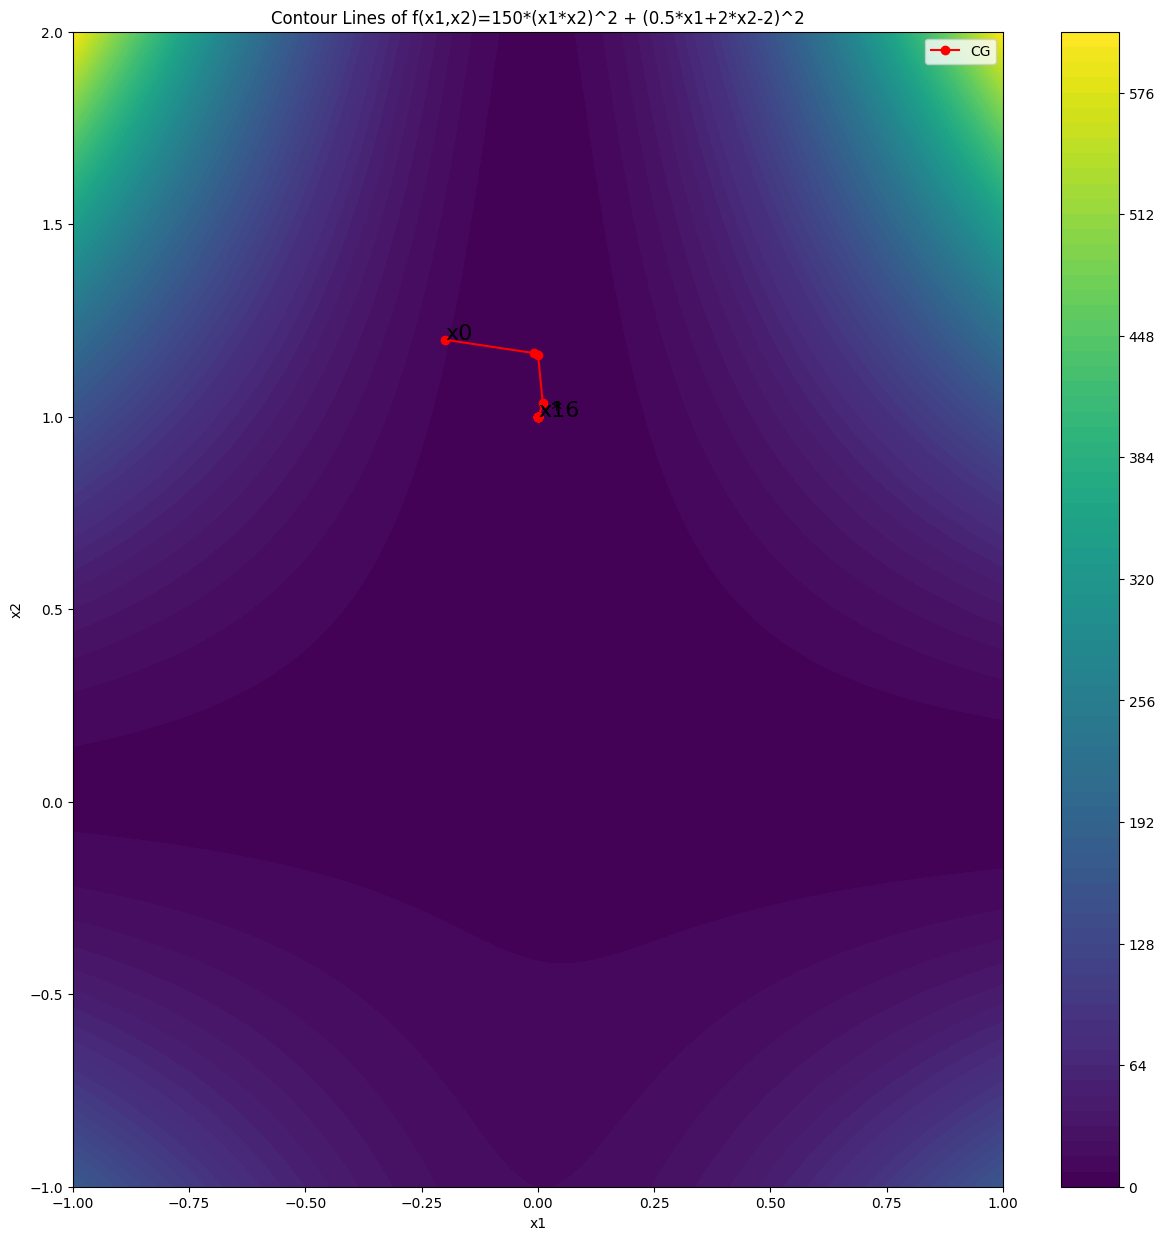

In [24]:
x_star = np.array([0,1])
_plot_contour_map(f=fct_2, x_min=-1, x_max=1, y_min=-1, y_max=2, fct_name='150*(x1*x2)^2 + (0.5*x1+2*x2-2)^2', x_iter_cg=np.array(results[4]),  x_star=x_star)

In [25]:
results=Flechter_reeves_est(fct_2_dec, grad_estimate_np, np.array([-0.2, 1.2]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 17 
final x: [-1.76536346e-11  9.99999990e-01] 
gradient: 5.324902390427775e-07 
distance: 9.825200636660683e-09


In [26]:
c=Polak_ribiere(fct_2, grad_fct_2, np.array([-0.2, 1.2]),10**-6, 0.5,1)
print(f"Number of iterates: {c[0]} \nfinal x: {c[1]} \ngradient: {c[2]} \ndistance: {c[3]}")

Number of iterates: 11 
final x: [-5.69436337e-11  1.00000001e+00] 
gradient: 8.92436621767589e-07 
distance: 9.331355131079791e-09


In [27]:
c=Polak_ribiere_est(fct_2_dec, grad_estimate_np, np.array([-0.2, 1.2]),10**-6, 0.5, 1)

print(f"Number of iterates: {c[0]} \nfinal x: {c[1]} \ngradient: {c[2]} \ndistance: {c[3]}")

Number of iterates: 11 
final x: [-5.69933833e-11  1.00000001e+00] 
gradient: 8.924366239422168e-07 
distance: 9.331317909965993e-09


# Problem 2 (3.8, 0.1)

In [28]:
x_star_1 = np.array([4,0])
results=Flechter_reeves(fct_2, grad_fct_2, np.array([3.8, 0.1]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 14 
final x: [3.99999921e+00 3.90619201e-10] 
gradient: 6.076566486460851e-07 
distance: 7.896102276772505e-07


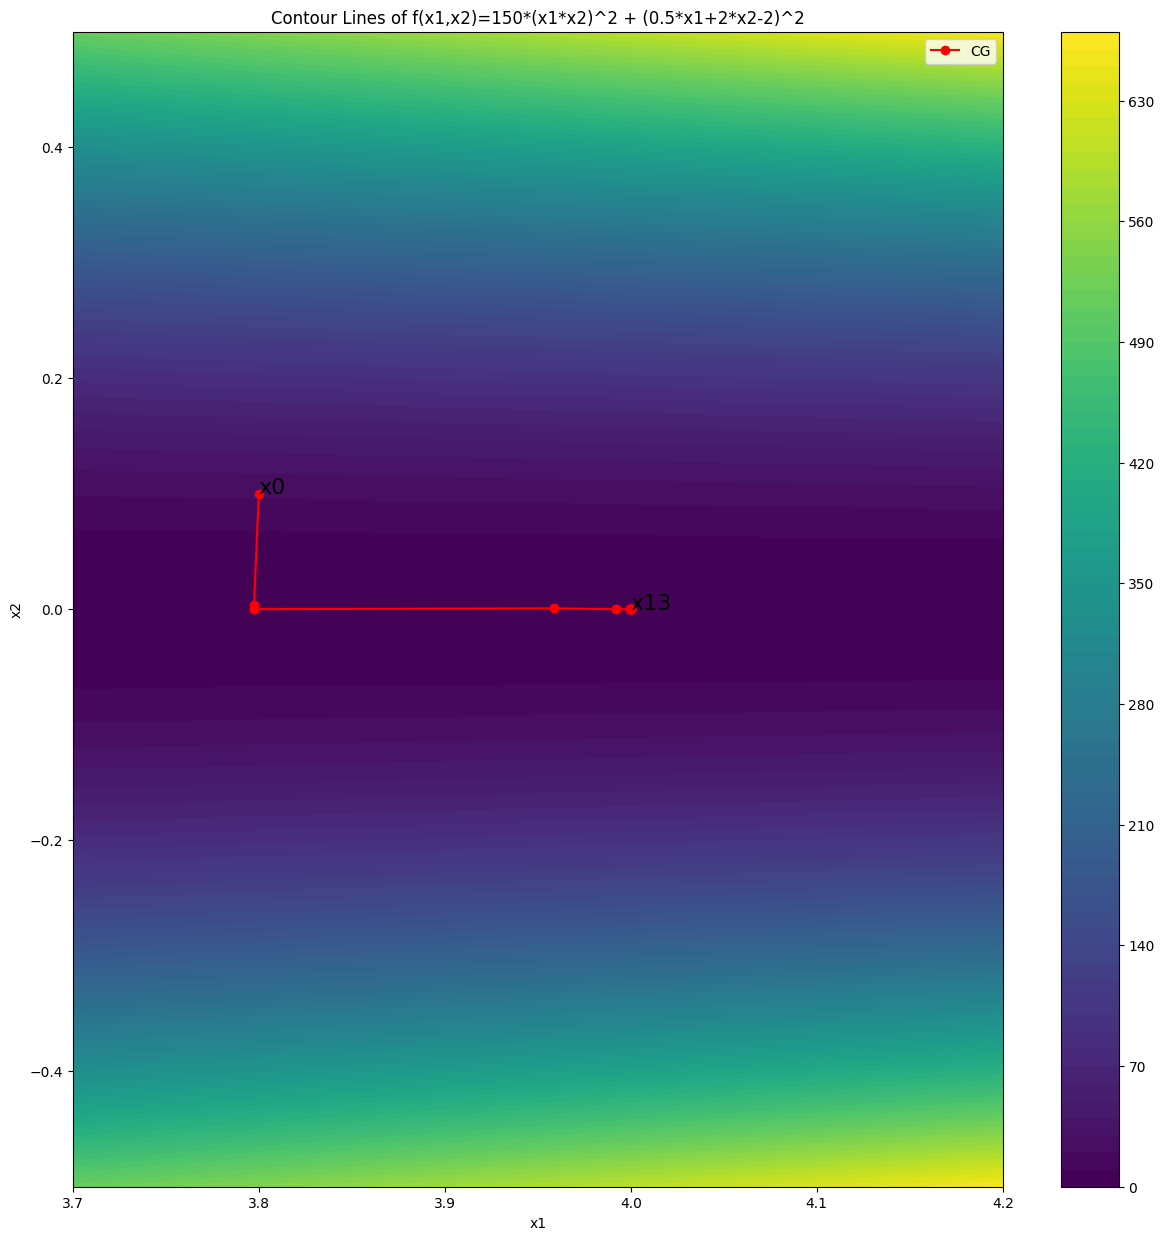

In [29]:
x_star = np.array([0,1])
_plot_contour_map(f=fct_2, x_min=3.7, x_max=4.2, y_min=-0.5, y_max=0.5, fct_name='150*(x1*x2)^2 + (0.5*x1+2*x2-2)^2', x_iter_cg=np.array(results[4]),  x_star=x_star)

In [30]:
x_star_1 = np.array([4,0])
results=Flechter_reeves_est(fct_2_dec, grad_estimate_np, np.array([3.8, 0.1]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 18 
final x: [ 4.00000023e+00 -1.34067394e-10] 
gradient: 1.2747709548357563e-07 
distance: 2.288333737767851e-07


In [31]:
c=Polak_ribiere(fct_2, grad_fct_2, np.array([3.8, 0.1]),10**-6, 0.5,1)
print(f"Number of iterates: {c[0]} \nfinal x: {c[1]} \ngradient: {c[2]} \ndistance: {c[3]}")

Number of iterates: 19 
final x: [4.00000000e+00 1.43966936e-11] 
gradient: 1.3397998076579856e-07 
distance: 7.861959287202799e-10


In [32]:
c=Polak_ribiere_est(fct_2_dec, grad_estimate_np, np.array([3.8, 0.1]),10**-6, 0.5,1)
print(f"Number of iterates: {c[0]} \nfinal x: {c[1]} \ngradient: {c[2]} \ndistance: {c[3]}")

Number of iterates: 19 
final x: [4.00000000e+00 1.43384331e-11] 
gradient: 1.3397609275780353e-07 
distance: 7.665583689347727e-10


# Problem 2 (1.9, 0.6)

In [33]:
x_star_1 = np.array([4,0])
results=Flechter_reeves(fct_2, grad_fct_2, np.array([1.9, 0.6]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 62 
final x: [3.99999948e+00 2.07992650e-10] 
gradient: 4.766496669404978e-07 
distance: 5.249332532155534e-07


In [34]:
results=Flechter_reeves_est(fct_2_dec, grad_estimate_np, np.array([1.9, 0.6]),10**-6, 0.5,1)
print(f"Number of iterates: {results[0]} \nfinal x: {results[1]} \ngradient: {results[2]} \ndistance: {results[3]}")

Number of iterates: 53 
final x: [ 4.00000118e+00 -2.13678710e-10] 
gradient: 5.9312428506431e-07 
distance: 1.1777148970048163e-06


In [35]:
c=Polak_ribiere(fct_2, grad_fct_2, np.array([1.9, 0.6]),10**-6, 0.5,1)

print(f"Number of iterates: {c[0]} \nfinal x: {c[1]} \ngradient: {c[2]} \ndistance: {c[3]}")

Number of iterates: 18 
final x: [4.00000000e+00 4.77486637e-13] 
gradient: 4.4664753283532916e-07 
distance: 6.133024837097058e-10


In [36]:
c=Polak_ribiere_est(fct_2_dec, grad_estimate_np, np.array([1.9, 0.6]),10**-6, 0.5,1)

print(f"Number of iterates: {c[0]} \nfinal x: {c[1]} \ngradient: {c[2]} \ndistance: {c[3]}")

Number of iterates: 18 
final x: [4.00000000e+00 4.18563297e-13] 
gradient: 4.466451366645769e-07 
distance: 5.917983140468959e-10
